In [11]:
%matplotlib inline

import os
import math
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from io import BytesIO

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from sklearn.manifold import TSNE

In [12]:
from model import SimpleVLMSeq2Seq
from data import generate_clock_image, text_to_indices, generate_dataset, ClockVLMDataset

In [13]:
def text_to_indices(text, vocab):
    """Tokenize text (whitespace) and convert to indices using vocab."""
    return [vocab[token] for token in text.lower().split() if token in vocab]

In [14]:
def load_model(pth_path, device, vocab_size, embed_dim, text_hidden_dim, num_classes):
    model = SimpleVLM(vocab_size, embed_dim, text_hidden_dim, num_classes)
    model.load_state_dict(torch.load(pth_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def load_seq2seq_model(model_path, device, input_vocab_size, embed_dim, text_hidden_dim, output_vocab_size, output_seq_len):
    """
    Load the seq2seq model (instance of SimpleVLMSeq2Seq) from a checkpoint.
    """
    model = SimpleVLMSeq2Seq(input_vocab_size, embed_dim, text_hidden_dim, output_vocab_size, output_seq_len)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model



In [15]:
def extract_intermediate_representation(model, sample_img, sample_text, device):
    """
    Extract intermediate representations from the vision encoder using a forward hook.
    """
    activations = {}
    def hook_fn(module, input, output):
        activations["img_encoder"] = output.detach()
    hook_handle = model.img_encoder.register_forward_hook(hook_fn)
    
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_text = sample_text.unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model(sample_img, sample_text)
    hook_handle.remove()
    
    return activations["img_encoder"]


In [16]:
def compute_saliency_map_seq2seq(model, sample_img, sample_text, device):
    """
    Compute a gradient-based saliency map for the seq2seq model.
    We sum the logit scores of the predicted tokens across the output sequence.
    Returns the saliency map and the predicted token indices.
    """
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_img.requires_grad_()
    sample_text = sample_text.unsqueeze(0).to(device)
    
    model.zero_grad()
    output = model(sample_img, sample_text)  # shape: (1, seq_len, vocab_size)
    preds = output.argmax(dim=2)  # (1, seq_len)
    
    # Sum the logits for the predicted tokens.
    score = 0
    for i in range(output.shape[1]):
        token_logit = output[0, i, preds[0, i]]
        score += token_logit
    score.backward()
    
    # Compute saliency across the image channels.
    saliency, _ = torch.max(sample_img.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()
    return saliency, preds

In [17]:
def visualize_tsne_seq2seq(model, dataset, device, target_vocab):
    """
    Extract image features (from the vision encoder) for the full dataset,
    apply t‑SNE, and color the points by the hour (extracted from the target 5‑character string).
    """
    model.eval()
    features = []
    labels = []
    loader = DataLoader(dataset, batch_size=4, shuffle=False)
    inv_target_vocab = {v: k for k, v in target_vocab.items()}
    
    with torch.no_grad():
        for img, text, target_seq in loader:
            img = img.to(device)
            feat = model.img_encoder(img)
            feat = feat.view(feat.size(0), -1)  # (B, feature_dim)
            features.append(feat.cpu())
            
            # Convert each target sequence to string and extract hour.
            for seq in target_seq:
                seq_str = "".join([inv_target_vocab[int(ch)] for ch in seq])
                hour_label = int(seq_str.split(":")[0])
                labels.append(hour_label)
    features = torch.cat(features, dim=0).numpy()
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter, label='Hour')
    plt.title("t-SNE of Vision Encoder Features (Colored by Hour)")
    plt.show()
    plt.close()


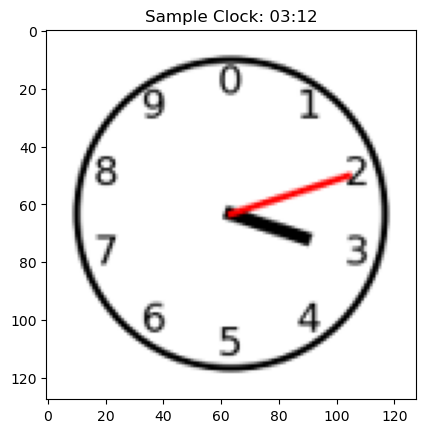

Extracted intermediate representation (vision encoder output) shape: torch.Size([1, 64, 1, 1])


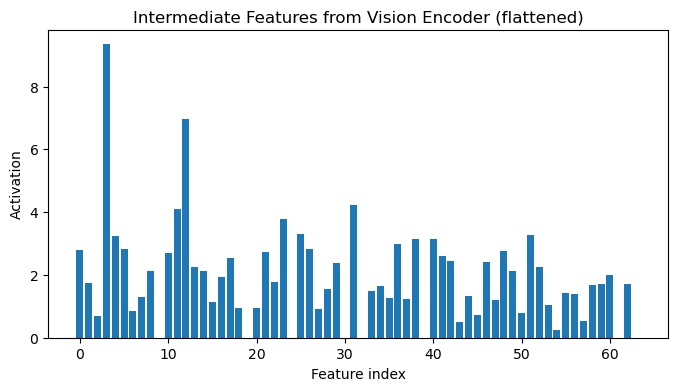

Predicted time for sample image: 03:12


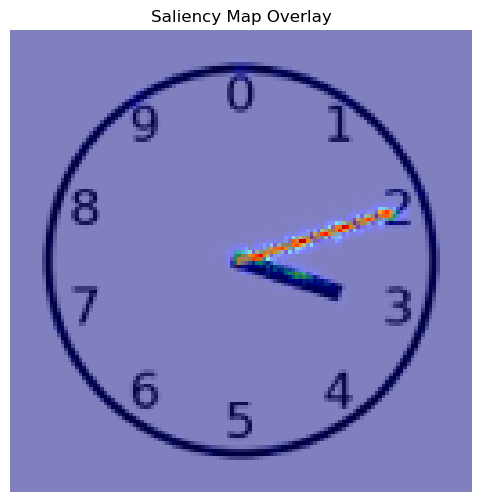

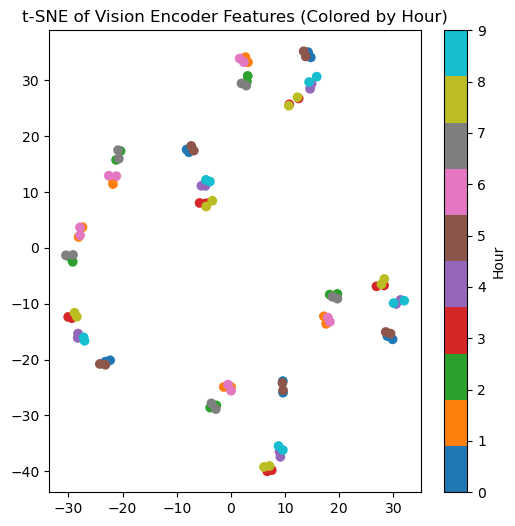

In [18]:
n = 10
image_size = 128
output_seq_len = 5   # "hh:mm" is 5 characters
prompt = "Tell me the time on the clock in hh:mm format"

# Define the vocabularies.
input_vocab_tokens = ["tell", "me", "the", "time", "on", "clock", "in", "hh:mm", "format"]
input_vocab = {token: idx for idx, token in enumerate(input_vocab_tokens)}
target_vocab = {ch: idx for idx, ch in enumerate("0123456789:")}

# Image transformation (must match training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Device configuration.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model hyperparameters.
embed_dim = 32
text_hidden_dim = 128
output_vocab_size = len(target_vocab)

# Load the saved seq2seq model.
model_path = "./models/clock_vlm_seq2seq_model_10_128_200_4_0.001.pth"
model = load_seq2seq_model(model_path, device, len(input_vocab), embed_dim, text_hidden_dim, output_vocab_size, output_seq_len)

# Generate one sample image for interpretability.
sample_img_np, time_str = generate_clock_image(hour=3, minute=2, n=n, size=image_size)
plt.imshow(sample_img_np)
plt.title(f"Sample Clock: {time_str}")
plt.show()

# Apply image transformation.
sample_img = transform(Image.fromarray(sample_img_np))
# Prepare text indices tensor for the prompt.
sample_text_indices = torch.tensor(text_to_indices(prompt, input_vocab), dtype=torch.long)

# ---------------------------
# 1. Intermediate Representation
# ---------------------------
rep = extract_intermediate_representation(model, sample_img, sample_text_indices, device)
rep_vector = rep.view(-1).cpu().numpy()
print("Extracted intermediate representation (vision encoder output) shape:", rep.shape)
plt.figure(figsize=(8,4))
plt.bar(np.arange(len(rep_vector)), rep_vector)
plt.title("Intermediate Features from Vision Encoder (flattened)")
plt.xlabel("Feature index")
plt.ylabel("Activation")
plt.show()
plt.close()

# ---------------------------
# 2. Saliency Map Computation
# ---------------------------
saliency, pred_seq = compute_saliency_map_seq2seq(model, sample_img, sample_text_indices, device)
inv_target_vocab = {v: k for k, v in target_vocab.items()}
pred_time = "".join([inv_target_vocab[int(tok)] for tok in pred_seq.squeeze().cpu().numpy()])
print("Predicted time for sample image:", pred_time)
plt.figure(figsize=(6,6))
orig_img = sample_img.cpu().permute(1,2,0).numpy()
orig_img = (orig_img * 0.5) + 0.5  # Unnormalize image.
plt.imshow(orig_img)
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Saliency Map Overlay")
plt.axis('off')
plt.show()
plt.close()

# ---------------------------
# 3. t-SNE Visualization of the Entire Dataset's Image Features
# ---------------------------
# Generate the full dataset.
images, time_strings = generate_dataset(n=n, size=image_size)
dataset = ClockVLMDataset(images, time_strings, prompt, input_vocab, target_vocab, transform=transform)
visualize_tsne_seq2seq(model, dataset, device, target_vocab)
